## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install moviepy
#! conda update pytorch torchvision -c pytorch
#! pip install pyro-ppl --upgrade
# pip install --upgrade Pillow
#!pip install seaborn

In [3]:
import os
import sys
import glob
import moviepy.editor as mpy
import numpy as np
import PIL.Image

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [4]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Image
from mpl_toolkits.mplot3d import Axes3D

In [5]:
from MODULES.utilities import *
from MODULES.vae_model import *

import torch
import pyro
#from pyro.infer import SVI, Trace_ELBO #,TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Check versions
print("pyro.__version__  --> ",pyro.__version__)
print("torch.__version__ --> ",torch.__version__)
assert(pyro.__version__.startswith('1.3'))
assert(torch.__version__.startswith('1.4'))

pyro.__version__  -->  1.3.0
torch.__version__ -->  1.4.0


# We expect to find the file "parameters.json" in the execution directory¶

In [6]:
params = load_json_as_dict("parameters.json")
print(params)

{'wdl.alias': 'disk_shading_yes_bg', 'wdl.memo': 'geco, inactive kl_logit', 'wdl.file_train': 'gs://ld-data-bucket/disk_shading/multi_disk_train_shading.pkl', 'wdl.file_test': 'gs://ld-data-bucket/disk_shading/multi_disk_test_shading.pkl', 'wdl.file_ckpt': 'gs://ld-results-bucket/ckpt/dummy.pkl', 'wdl.bucket_output': 'gs://ld-results-bucket', 'wdl.dir_output': 'merfish', 'wdl.notebook_name': 'MAIN.ipynb', 'wdl.git_repo': 'https://github.com/spacetx/spacetx-research.git', 'wdl.commit_or_branch': 'master', 'simulation': {'__comment': 'there are 3 types of runs: scratch, resume, pre_trained', 'type': 'scratch', 'MAX_EPOCHS': 30001, 'TEST_FREQUENCY': 5, 'CHECKPOINT_FREQUENCY': 20, 'batch_size': 128}, 'architecture': {'__comment': 'architecture parameters, level_zwhere_output is between 0 and n_max_pool included', 'dim_zwhat': 25, 'dim_zmask': 25, 'dim_zwhere': 4, 'dim_logit': 1, 'cropped_size': 28, 'n_max_pool': 4, 'level_zwhere_and_logit_output': 2, 'level_background_output': 4, 'n_ch_out

# prepare the file names

In [7]:
# CROMWELL will localize: 
# gs://ld-data-bucket/data/fashionmnist_train.pkl -> execution_dir/ld-data-bucket/data/fashionmnist_train.pkl
# Therefore I just need to remove  "gs://"
# Note that every path is relative to the execution_dir

train_file = os.path.basename(params["wdl.file_train"])
test_file = os.path.basename(params["wdl.file_test"])
ckpt_file = os.path.basename(params["wdl.file_ckpt"])
dir_output = params["wdl.dir_output"]

# create output directionry if it does nto exists
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

# Save input_json_file to output dir
json_param_file = os.path.join(dir_output, "parameters.json")
save_dict_as_json(params,json_param_file)

# checks
assert os.path.isfile(train_file)
assert os.path.isfile(test_file)
assert os.path.isfile(ckpt_file)
    
print(train_file)
print(test_file)
print(dir_output)
print(json_param_file)
print(ckpt_file)

multi_disk_train_shading.pkl
multi_disk_test_shading.pkl
merfish
merfish/parameters.json
dummy.pkl


# SYNTHETIC DATA

In [8]:
print("get the data")
#train_file="multi_disk_train_shading_bg_v3.pkl"
#test_file="multi_disk_test_shading_bg_v3.pkl"
#multi_mnist_test_no_bg.pkl

#train_file="multi_mnist_train_simple_v3.pkl"
#test_file="multi_mnist_test_simple_v3.pkl"

#train_file="multi_disk_train_shading_bg.pkl"
#test_file="multi_disk_test_shading_bg.pkl"

#x_train, y_train = load_obj(train_file)
#train_loader = LoaderInMemory(x=x_train, 
#                              y=y_train, 
#                              pin_in_cuda_memory=torch.cuda.is_available(),
#                              batch_size=params["simulation"]["batch_size"],  
#                              shuffle=True)
#                               
#x_test, y_test = load_obj(train_file)
#test_loader = LoaderInMemory(x=x_test, 
#                             y=y_test, 
#                             pin_in_cuda_memory=torch.cuda.is_available(),
#                             batch_size=params["simulation"]["batch_size"],  
#                             shuffle=False)
#
#train_loader.check_batch()

get the data


In [9]:
#test_loader.check_batch()

# REAL DATASETS: Import image and preproces

FROM HERE:
1. import a simplge VOF directly from microscope (should be unsigned 64)
2. do noise analysis for a single FOV without resizing.
3. for each FOV extract a,b
4. do ascombe transformation for only one FOV
4. do segmentation of a single FOV

In [10]:
#import torchvision.transforms as transforms
#import PIL.Image 
#import PIL.ImageOps
#import skimage.exposure
#PIL.Image.MAX_IMAGE_PIXELS = None

In [11]:
#x,y = 5000,5000
#np_raw_fov = np.array(PIL.Image.open("smFISH_single_FOV_v2.tif"))
#np_raw_all = np.array(PIL.Image.open("smFISH_stitched_OLEH.tif").crop((x,y,x+5*2048,y+5*2048)))

In [12]:
#print(np_raw_fov.shape, np.min(np_raw_fov.flatten()), np.max(np_raw_fov.flatten()))
#print(np_raw_all.shape, np.min(np_raw_all.flatten()), np.max(np_raw_all.flatten()))

In [13]:
#torch_raw_fov = torch.from_numpy(np_raw_fov.astype(float))
#torch_raw_all = torch.from_numpy(np_raw_all.astype(float))
#if torch.cuda.is_available():
#    torch_raw_fov = torch_raw_fov.cuda()
#    torch_raw_all = torch_raw_all.cuda()
#
#print(torch_raw_fov.shape, torch.min(torch_raw_fov), torch.max(torch_raw_fov))
#print(torch_raw_all.shape, torch.min(torch_raw_all), torch.max(torch_raw_all))

In [14]:
#figure, axes = plt.subplots(ncols=2, figsize=(24, 24))
#axes[0].imshow(torch_raw_fov.cpu(), cmap='gray')
#axes[1].imshow(torch_raw_all.cpu(), cmap='gray')

In [15]:
#x_fov_1,y_fov_1 = estimate_noise(torch_raw_fov, radius_nn=1)
#x_all_1,y_all_1 = estimate_noise(torch_raw_all, radius_nn=1)
#x_fov_3,y_fov_3 = estimate_noise(torch_raw_fov, radius_nn=3)
#x_all_3,y_all_3 = estimate_noise(torch_raw_all, radius_nn=3)

In [16]:
#avg_x_fov_1, avg_y_fov_1 = compute_average_in_each_bin(x_fov_1, y_fov_1)
#avg_x_all_1, avg_y_all_1 = compute_average_in_each_bin(x_all_1, y_all_1)
#avg_x_fov_3, avg_y_fov_3 = compute_average_in_each_bin(x_fov_3, y_fov_3)
#avg_x_all_3, avg_y_all_3 = compute_average_in_each_bin(x_all_3, y_all_3)

In [17]:
#plt.plot(avg_x_fov_1.cpu(),avg_y_fov_1.cpu(), 'x', label='fov_1')
#plt.plot(avg_x_all_1.cpu(),avg_y_all_1.cpu(), 'o', label='all_1')
#plt.plot(avg_x_fov_3.cpu(),avg_y_fov_3.cpu(), '-', label='fov_3')
#plt.plot(avg_x_all_3.cpu(),avg_y_all_3.cpu(), '.-', label='all_3')
#plt.legend()
#plt.grid()

# Load numpy array to torch.Tensor

In [18]:
import skimage.exposure
import skimage.transform
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

### Read raw Image as float

In [19]:
img_raw = np.array(PIL.Image.open("smFISH_stitched_OLEH.tif").convert('F'))
w_raw, h_raw = img_raw.shape
print(img_raw.shape, np.min(img_raw.flatten()), np.max(img_raw.flatten()))

(21505, 21505) 0.0 16916.0


### Resize to smaller size using bilinear interpolation
pil_resize = pil_file.convert("F").resize((w_new, h_new), resample=pilimage.BILINEAR)

In [20]:
reduction_factor = 8
w_new, h_new = int(w_raw/reduction_factor) , int(h_raw/reduction_factor)
img_tmp1 = skimage.transform.resize(img_raw, output_shape=[w_new, h_new], order=1, clip=True, anti_aliasing=True, preserve_range=True)
print(img_tmp1.shape, np.min(img_tmp1.flatten()), np.max(img_tmp1.flatten()))

(2688, 2688) 0.0 16326.58257351412


### Rescale the intensities in (0,1)

In [21]:
img_tmp2 = skimage.exposure.rescale_intensity(img_tmp1, in_range='image', out_range='dtype')
print(img_tmp2.shape, np.min(img_tmp2.flatten()), np.max(img_tmp2.flatten()))

(2688, 2688) 0.0 1.0


### Enhance the contrast

In [22]:
#img_tmp3 = skimage.exposure.equalize_hist(img_tmp2, mask=img_tmp2>0)
img_tmp3 = skimage.exposure.rescale_intensity(img_tmp2, in_range='image', out_range='dtype')
print(img_tmp3.shape, np.min(img_tmp3.flatten()), np.max(img_tmp3.flatten()))

(2688, 2688) 0.0 1.0


### Visualize the result

tensor([2172]) tensor([463])


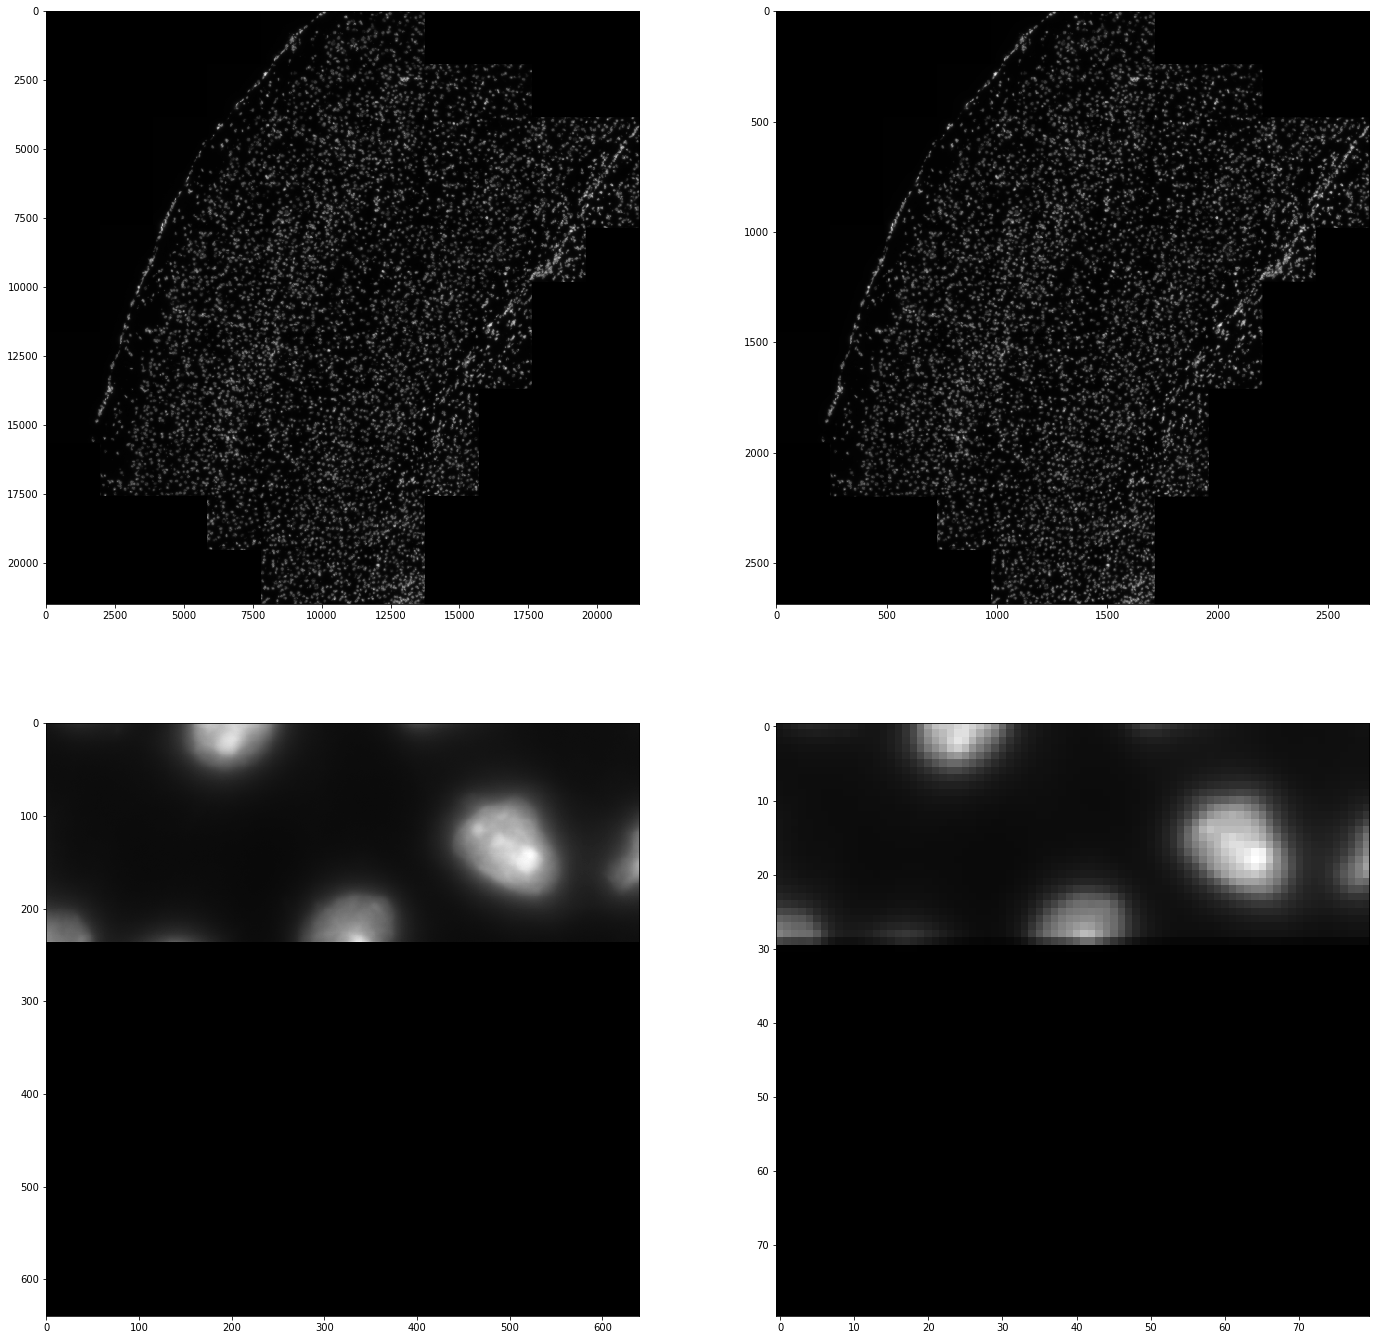

In [23]:
delta = 80
iw = torch.randint(low=0, high=img_tmp3.shape[-2]-delta, size=[1])
ih = torch.randint(low=0, high=img_tmp3.shape[-1]-delta, size=[1])
print(iw,ih)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axes[0,0].imshow(img_raw, cmap='gray')
axes[0,1].imshow(img_tmp3, cmap='gray')
axes[1,0].imshow(img_raw[...,iw*reduction_factor:(iw+delta)*reduction_factor,ih*reduction_factor:(ih+delta)*reduction_factor], cmap='gray')
axes[1,1].imshow(img_tmp3[...,iw:iw+delta,ih:ih+delta], cmap='gray')

In [24]:
# Conversion to torch

In [25]:
img_torch = torch.from_numpy(img_tmp3).float()[None,None]
print(img_torch.shape, torch.min(img_torch), torch.max(img_torch))

torch.Size([1, 1, 2688, 2688]) tensor(0.) tensor(1.)


In [26]:
BATCH_SIZE = params["simulation"]["batch_size"]
random_crops_test = ManyRandomCropsTensor(desired_w=80, desired_h=80, n_crops=2000, mask=img_torch>0)
random_crops_train = ManyRandomCropsTensor(desired_w=80, desired_h=80, n_crops=BATCH_SIZE, mask=img_torch>0)

train_loader = LoaderInMemory(x=img_torch, 
                              y=None, 
                              data_augmentation=random_crops_train, 
                              transform_y=False, 
                              pin_in_cuda_memory=torch.cuda.is_available(),
                              batch_size=1, 
                              drop_last=False, 
                              shuffle=True)

test_loader = LoaderInMemory(x=random_crops_test(img_torch), 
                              y=None, 
                              data_augmentation=None, 
                              transform_y=False, 
                              pin_in_cuda_memory=torch.cuda.is_available(),
                              batch_size=BATCH_SIZE, 
                              drop_last=False, 
                              shuffle=False)

Dataset lenght: 1
imgs.shape torch.Size([1, 1, 2688, 2688])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')
x,y,index shapes -> torch.Size([128, 1, 80, 80]) torch.Size([128]) torch.Size([128])


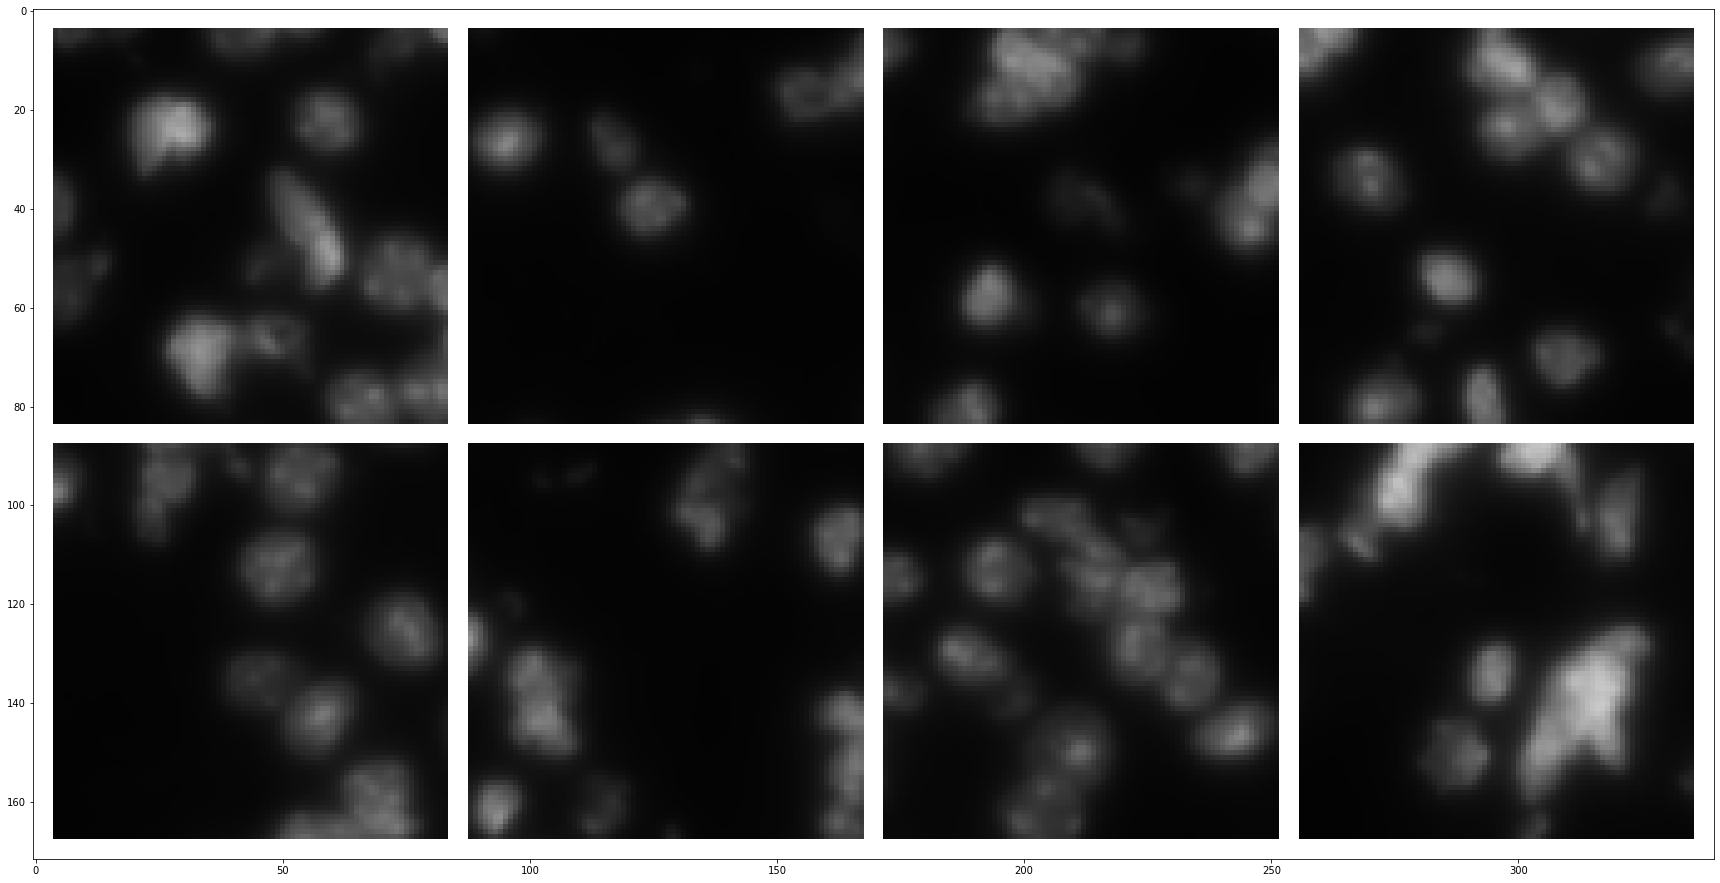

In [27]:
train_loader.check_batch()

Dataset lenght: 2000
imgs.shape torch.Size([2000, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(1.5607e-07, device='cuda:0')
x,y,index shapes -> torch.Size([128, 1, 80, 80]) torch.Size([128]) torch.Size([128])


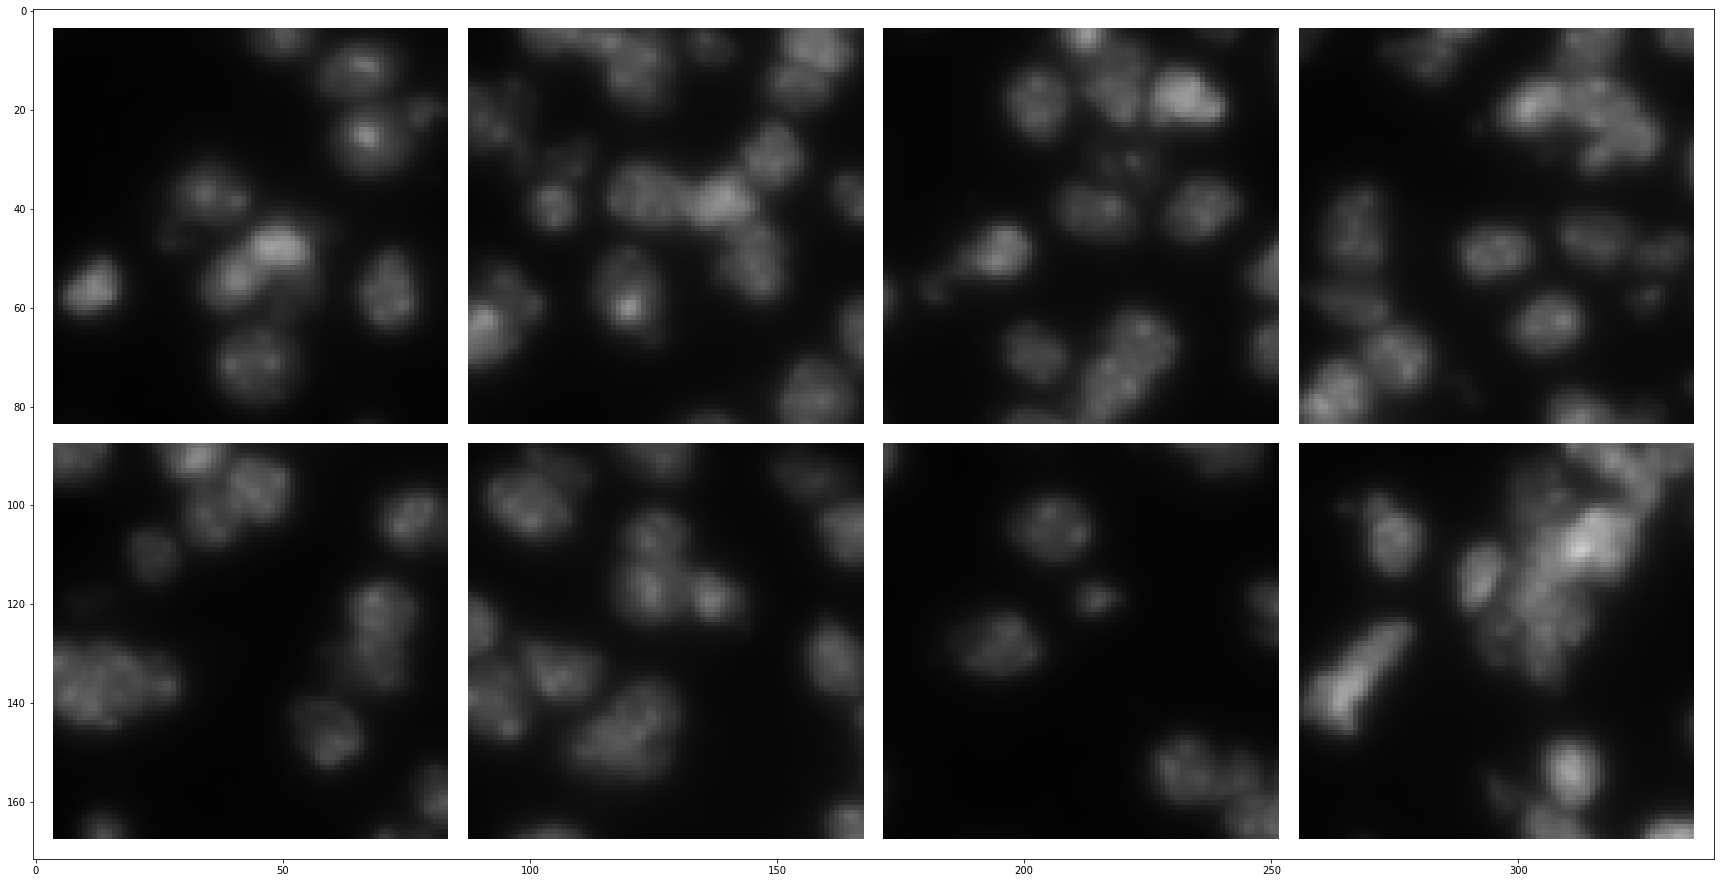

In [28]:
test_loader.check_batch()

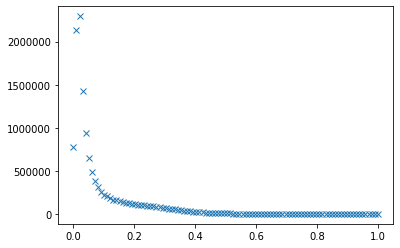

In [29]:
index = torch.linspace(0,1,100)
count = torch.histc(test_loader.x, bins=100)
plt.plot(index,count.cpu(),'x')

# Instantiate model and optimizer

In [30]:
vae = CompositionalVae(params)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
#vae

# Does the untrained generator match the data

torch.Size([128, 1, 80, 80]) torch.Size([128]) torch.Size([128])


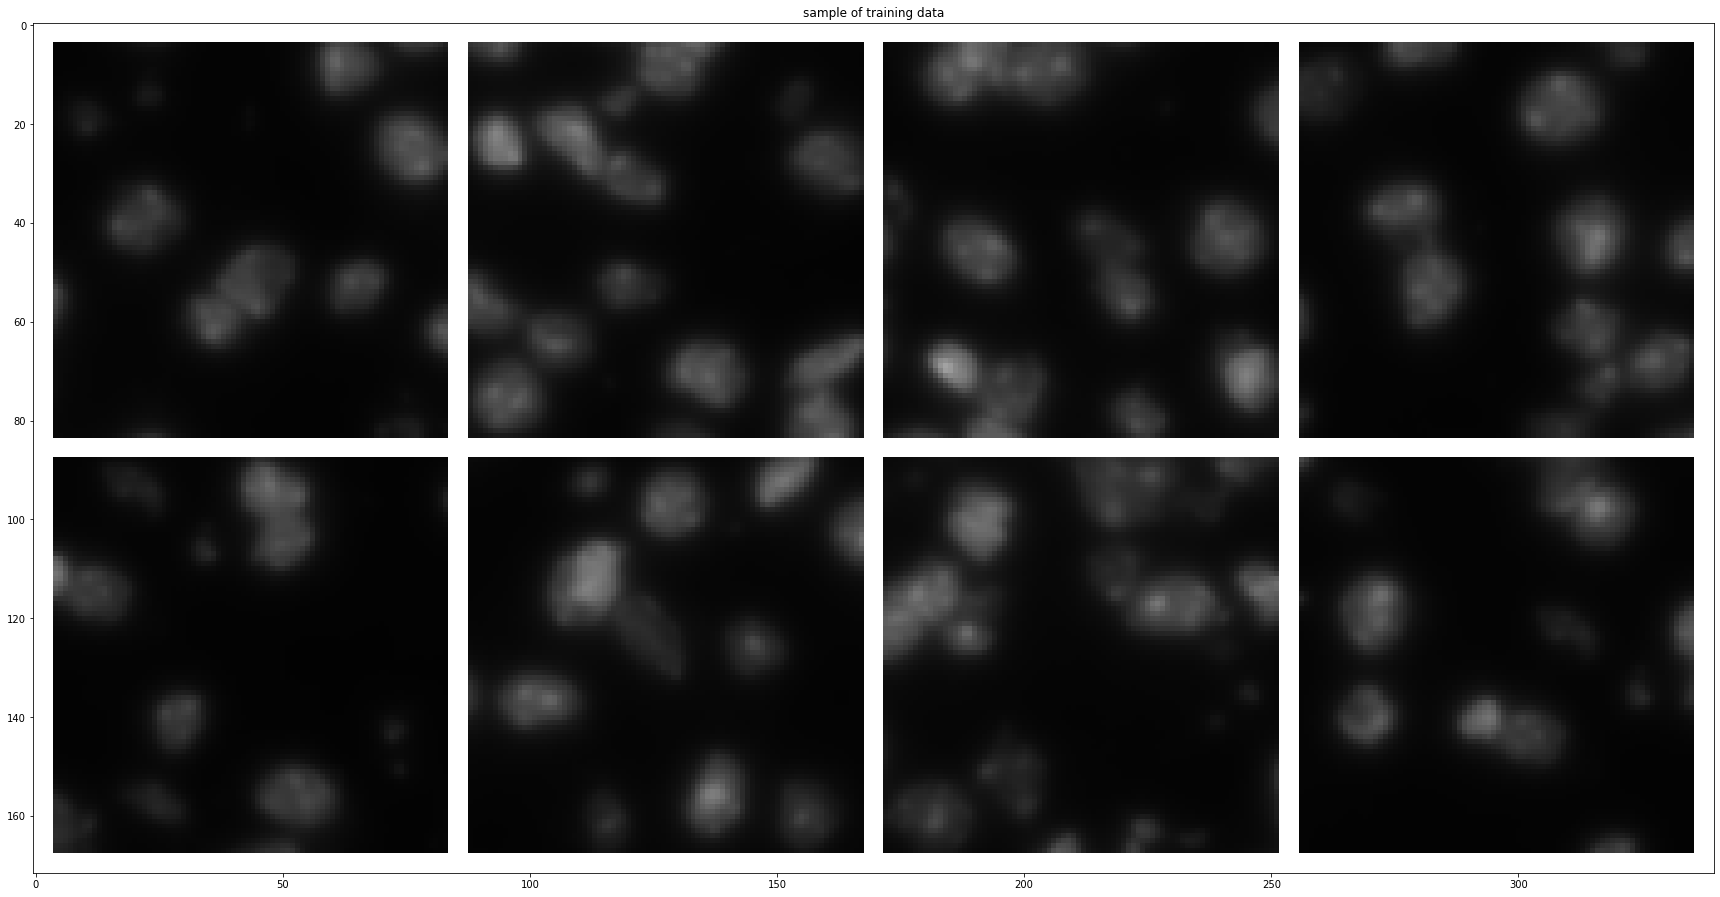

In [31]:
x,y,index = train_loader.load(batch_size=1)
print(x.shape, y.shape, index.shape)
show_batch(x[:8], n_col=4, n_padding=4, pad_value=1, title="sample of training data", figsize=(24,24))

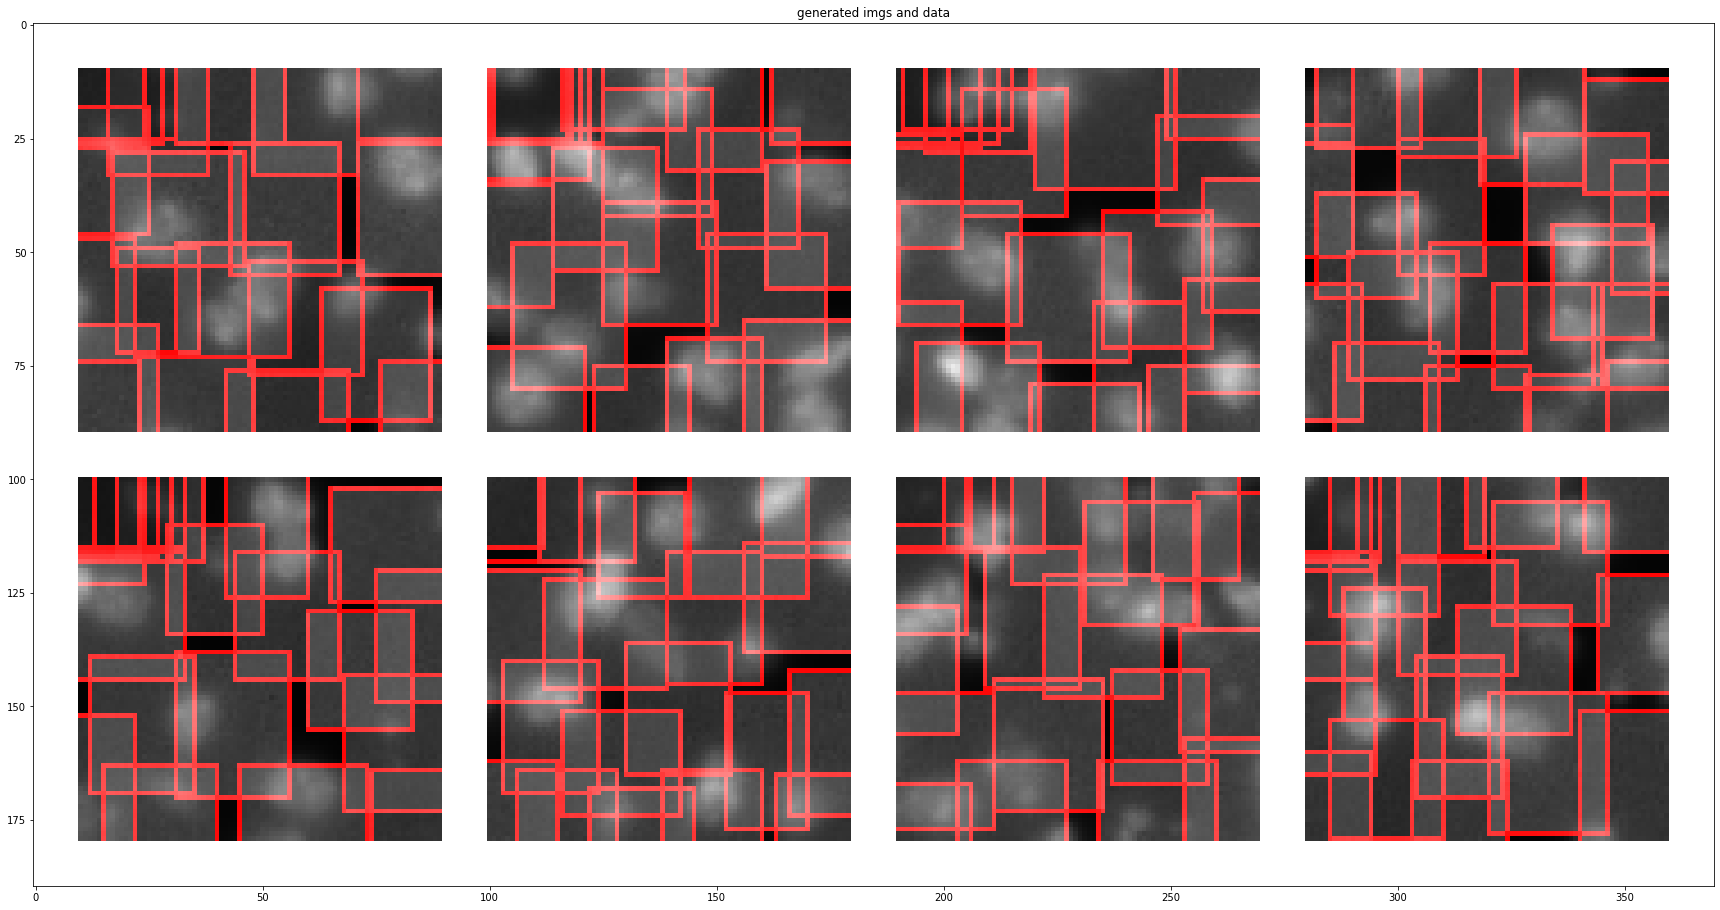

In [32]:
auch = vae.generate(imgs_in=x, draw_bounding_box=True)
show_batch(auch.imgs[:8]+x[:8], title="generated imgs and data", figsize=(24,24))

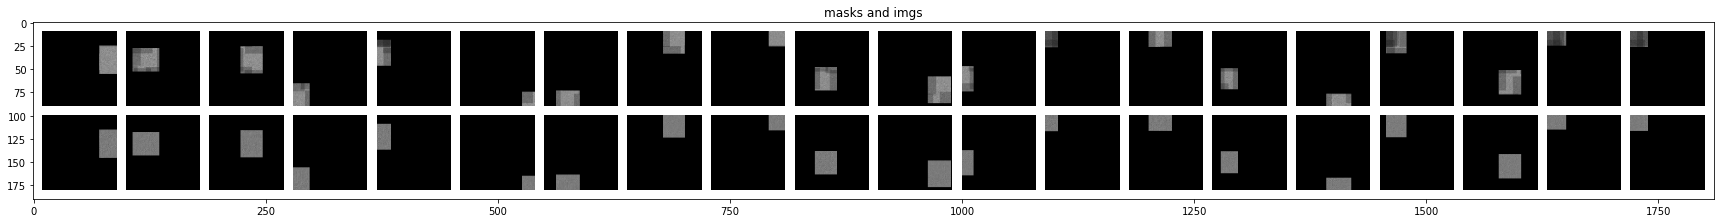

In [33]:
big_mask = auch.inference.big_mask[:,0]
big_img = auch.inference.big_img[:,0]
tmp = torch.cat((big_mask, big_img),dim=0)
show_batch(tmp, n_col=tmp.shape[0]//2, title="masks and imgs", figsize=(24,24))

# Does the segmentation work

torch.Size([8, 1, 80, 80]) torch.Size([8, 3, 80, 80])


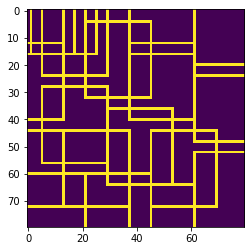

In [34]:
x,y,index = test_loader.load(batch_size=8)
seg_mask = vae.segment(x, draw_bounding_box=True)

print(x.shape,seg_mask.shape)
plt.imshow(seg_mask[0,0].cpu())

In [35]:
#print(train_loader.x.shape)
#seg_mask = vae.segment_with_tiling(train_loader.x, crop_w=80, crop_h=80, stride_w=60, stride_h=60, n_objects_max_per_patch=None, draw_bounding_box=True)

#print(seg_mask.shape)
#plt.imshow(seg_mask[0,0].cpu())

# Check the constraints

In [36]:
vae.dict_soft_constraints

{'__comment': 'all the parameters about the soft constraints',
 'fg_pixel_fraction': {'__comment': 'Fraction of fg_pixel needs to be in a specific range',
  'lower_bound_value': 0.25,
  'lower_bound_width': 0.05,
  'lower_bound_strength': 0.1,
  'lower_bound_exponent': 2,
  'upper_bound_value': 0.65,
  'upper_bound_width': 0.05,
  'upper_bound_strength': 0.1,
  'upper_bound_exponent': 2},
 'overlap': {'__comment': 'cost which discourages masks from overlapping',
  'strength': 0.001,
  'exponent': 1}}

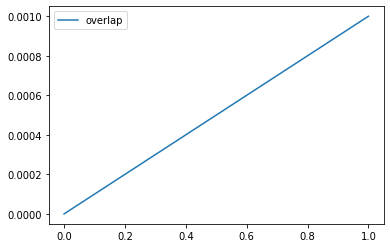

In [37]:
x1=torch.linspace(0,1,100)
y1=sample_from_constraints_dict(dict_soft_constraints=vae.dict_soft_constraints,
                                var_name="overlap", 
                                var_value=x1, 
                                verbose=False)
plt.plot(x1,y1, label="overlap")
plt.legend()

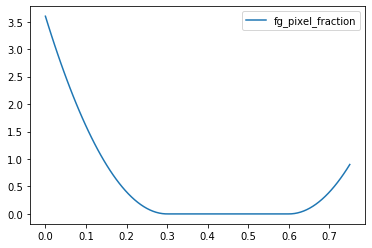

In [38]:
x=torch.linspace(0,0.75,100)
y=sample_from_constraints_dict(dict_soft_constraints=vae.dict_soft_constraints,
                               var_name="fg_pixel_fraction", 
                               var_value=x, 
                               verbose=False)
plt.plot(x, y, label="fg_pixel_fraction")
plt.legend()

# There are 3 possible simulation types: scratch, resumed, pretrained

In [39]:
print("simulation type = "+str(params["simulation"]["type"]))

if (params["simulation"]["type"] == "scratch"):
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999

elif (params["simulation"]["type"] == "resumed"):
        
    resumed = load_info(path=ckpt_file, 
                        load_epoch=True, 
                        load_history=True)
    epoch_restart = resumed.epoch
    history_dict = resumed.history_dict
    min_test_loss = min(history_dict["test_loss"])
    
    load_model_optimizer(path=ckpt_file, 
                         model=vae,
                         optimizer=optimizer)

elif (params["simulation"]["type"] == "pretrained"):
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999
    
    load_model_optimizer(path=ckpt_file, 
                         model=vae,
                         optimizer=None)
    
# instantiate the scheduler if necessary    
if params["optimizer"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, dict_params_scheduler=params["optimizer"])

simulation type = scratch


# Training loop

In [40]:
TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]

In [ ]:
epoch_restart = 0
for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart    
    
    ## vae.is_geco_selftuning = False
    ## vae.geco_mu_detached = linear_interpolation(epoch, 
    ##                                             values=[0.95,0.5],
    ##                                             times=[100,500])
    
    vae.prob_corr_factor=linear_interpolation(epoch, 
                                              values=params["shortcut_prob_corr_factor"]["values"],
                                              times=params["shortcut_prob_corr_factor"]["times"])
        
    #with torch.autograd.set_detect_anomaly(True):
    with torch.autograd.set_detect_anomaly(False):
        vae.train()
        with torch.enable_grad():
            train_metrics = process_one_epoch(model=vae, 
                                              dataloader=train_loader, 
                                              optimizer=optimizer, 
                                              batch_size=BATCH_SIZE, 
                                              verbose=(epoch==0), 
                                              weight_clipper=None)
        with torch.no_grad():        
            s = pretty_print_metrics(epoch, train_metrics, is_train=True)
            print(s,"prob_factor=%.4f" %(vae.prob_corr_factor))
            
            history_dict = append_dict_to_dict(source=train_metrics, 
                                               target=history_dict,
                                               prefix_exclude="wrong_examples",
                                               prefix_to_add="train_")
        
    if params["optimizer"]["scheduler_is_active"]:
        scheduler.step(epoch=epoch)
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        with torch.no_grad():
            test_metrics = process_one_epoch(model=vae, 
                                             dataloader=test_loader, 
                                             optimizer=optimizer, 
                                             verbose=(epoch==0), 
                                             weight_clipper=None)
        
            s = pretty_print_metrics(epoch, test_metrics, is_train=False)
            print(s,"prob_factor %.4f" %(vae.prob_corr_factor))
        
            history_dict = append_dict_to_dict(source=train_metrics, 
                                               target=history_dict,
                                               prefix_exclude="wrong_examples",
                                               prefix_to_add="test_")
        
            test_loss = test_metrics["loss"]
            min_test_loss = min(min_test_loss, test_loss)
            
            if((test_loss == min_test_loss) or ((epoch % CHECKPOINT_FREQUENCY) == 0)): 
                checkpoint_file = os.path.join(dir_output, "ckp_"+str(epoch)+".pkl")
                history_file = os.path.join(dir_output, "history_"+str(epoch)+".pkl")
            
                save_everything(model=vae, 
                                optimizer=optimizer, 
                                history_dict=history_dict, 
                                epoch=epoch, 
                                hyperparams_dict=params, 
                                path=checkpoint_file)
            
                save_dict_as_json(history_dict, path=history_file)
                print("saved files -> "+checkpoint_file+"  "+history_file)

Train [epoch    1] loss=396.737, nll=374.957, reg=0.116, kl_tot=0.309, sparsity=21.355, acc=0.000, n_obj=4.039, geco_sp=0.998, geco_nll=1.000 prob_factor=0.5000
Train [epoch    2] loss=105.634, nll=72.601, reg=0.134, kl_tot=0.311, sparsity=21.220, acc=0.000, n_obj=3.367, geco_sp=0.995, geco_nll=1.157 prob_factor=0.5000
Train [epoch    3] loss=74.515, nll=44.673, reg=0.165, kl_tot=0.311, sparsity=20.842, acc=0.000, n_obj=3.305, geco_sp=0.992, geco_nll=1.192 prob_factor=0.5000
Train [epoch    4] loss=63.989, nll=35.358, reg=0.184, kl_tot=0.311, sparsity=20.643, acc=0.000, n_obj=3.328, geco_sp=0.989, geco_nll=1.215 prob_factor=0.5000
Train [epoch    5] loss=63.590, nll=34.694, reg=0.178, kl_tot=0.311, sparsity=20.462, acc=0.000, n_obj=3.328, geco_sp=0.986, geco_nll=1.234 prob_factor=0.5000
Test  [epoch    5] loss=63.814, nll=33.865, reg=0.145, kl_tot=0.299, sparsity=21.195, acc=0.000, n_obj=3.612, geco_sp=0.986, geco_nll=1.253 prob_factor 0.5000
saved files -> merfish/ckp_5.pkl  merfish/h

# Test generator after training

In [ ]:
imgs_in_tmp, labels, index = train_loader.load(batch_size=8)
auch = vae.generate(imgs_in=imgs_in_tmp[:1], draw_bounding_box=True)

pmap_gen = show_batch(auch.inference.p_map[:8], title="generated p_map")
imgs_gen = show_batch(auch.imgs[:8], title="generated p_map")
display(pmap_gen, imgs_gen)

big_mask = auch.inference.big_mask[:,0]
big_img = auch.inference.big_img[:,0]
tmp = torch.cat((big_mask, big_img),dim=0)
show_batch(tmp, n_col=tmp.shape[0]//2, title="masks and imgs")

# Check the segmentation results

In [ ]:
#seg_mask = vae.segment_with_tiling(train_loader.x[...,2000:2400,2000:2400], 
#                                   crop_w=80, crop_h=80, 
#                                   stride_w=60, stride_h=60, n_objects_max_per_patch=10)

x,y,index = test_loader.load(batch_size=8)
seg_mask = vae.segment(x)
plt.imshow(seg_mask[0,0].cpu())
    
#figure, axes = plt.subplots(ncols=2, figsize=(24, 24))
#axes[1].imshow(train_loader.x[0,0,2000:2400,2000:2400], cmap='gray')
#axes[0].imshow(seg_mask[0,0])

# Check the results

In [ ]:
train_metrics

In [ ]:
for k,v in history_dict.items():
    if k.startswith("train"):
        print(k," -->", history_dict[k][-3:])

In [ ]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), 
         sign*np.array(history_dict["train_loss"])+y_shift,'-')
plt.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss"])*TEST_FREQUENCY,TEST_FREQUENCY), 
         sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax=2)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()

fig_file = os.path.join(dir_output, "train.png")
plt.savefig(fig_file)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('n obj av', color=color)
ax1.plot(np.arange(0, len(history_dict["train_n_obj"])),
         history_dict["train_n_obj"], 'o', color=color, label="train")
ax1.plot(np.arange(0, len(history_dict["test_n_obj"])*TEST_FREQUENCY, TEST_FREQUENCY),
         history_dict["test_n_obj"], 'x-', color=color, label="test")

ymin=min(params["GECO"]["target_n_obj"])
ymax=max(params["GECO"]["target_n_obj"])
ax1.plot(ymin*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_min")
ax1.plot(ymax*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_max")

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
#ax1.set_ylim([1000,1870])
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, len(history_dict["train_accuracy"])),
         history_dict["train_accuracy"],'x', color=color)
ax2.plot(np.arange(0, len(history_dict["test_accuracy"])*TEST_FREQUENCY, TEST_FREQUENCY),
         history_dict["test_accuracy"],'-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
#ax2.set_ylim([0.97,1.0])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "accuracy.png")
plt.savefig(fig_file)

In [ ]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.plot(np.array(history_dict["train_sparsity"]),'-',label='sparsity')
#ax.set_ylim([0,10])
ax.grid()
ax.legend()

ax2.plot(np.array(history_dict["train_kl_what"]),'-',label='kl zwhat')
ax2.plot(np.array(history_dict["train_kl_mask"]),'-',label='kl zmask')
ax2.plot(np.array(history_dict["train_kl_where"]),'-',label='kl zwhere')
#ax2.plot(np.array(history_dict["train_kl_logit"]),'-',label='kl logit')
ax2.set_ylim([0,1])
ax2.grid()
ax2.legend()

#ax3.plot(history_dict["soft_cost_total_raw"],'-',label='cost total')
ax3.plot(history_dict["train_cost_overlap"],'-',label='cost overlap')
ax3.plot(history_dict["train_cost_fg_pixel_fraction"],'-',label='cost fg_pixel_fraction')
#ax3.plot(history_dict["train_cost_volume_mask_fraction"],'-',label='cost volume_mask_fraction')
#ax3.plot(history_dict["train_cost_prob_map_integral"],'-',label='cost prob_map_integral')
#ax3.plot(history_dict["train_cost_prob_map_fraction"],'-',label='cost prob_map_fraction')
#ax3.plot(history_dict["train_cost_prob_map_TV"],'-',label='cost prob_map_TV')
#ax3.plot(history_dict["train_reg"],'-',label='all_reg')
#ax3.set_ylim([0,1.1])
ax3.grid()
ax3.legend()

ax4.plot(history_dict["train_loss"],'-',label='loss')
ax4.plot(np.array(history_dict["train_geco_sparsity"])*np.array(history_dict["train_sparsity"]),'x-',label='scaled_sparsity')
ax4.plot(np.array(history_dict["train_geco_nll"])*np.array(history_dict["train_nll"]),'o-',label='scaled_nll')
ax4.plot(history_dict["train_kl_tot"],'+',label='kl_tot')
ax4.plot(history_dict["train_reg"],'.',label='reg')
ax4.set_ylim([0,5])
ax4.grid()
ax4.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "metrics.png")
plt.savefig(fig_file)

In [ ]:
params["GECO"]

In [ ]:
fontsize=20
labelsize=20
f = plt.figure(figsize=(20,20))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)

#-----------------------------------

color = 'tab:red'
ax1.set_xlabel('epochs', fontsize=fontsize)
ax1.set_ylabel('n obj av', fontsize=fontsize, color=color)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.plot(history_dict["train_n_obj"], '.--', color=color, label="n_object")

ymin=min(params["GECO"]["target_n_obj"])
ymax=max(params["GECO"]["target_n_obj"])
ax1.plot(ymin*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_min")
ax1.plot(ymax*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_max")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax1b = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax1b.set_xlabel('epochs', fontsize=fontsize)
ax1b.set_ylabel('geco_sparsity', color=color, fontsize=fontsize)
plt.plot(history_dict["train_geco_sparsity"],'-',label="geco_sparsity",color=color)
ax1b.tick_params(axis='y', labelcolor=color)
ax1b.grid()

##------------------------------------

color = 'tab:red'
ax2.set_xlabel('epochs', fontsize=fontsize)
ax2.set_ylabel('nll av', fontsize=fontsize, color=color)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.plot(history_dict["train_nll"], '.--', color=color, label="nll av")

ymin=min(params["GECO"]["target_nll"])
ymax=max(params["GECO"]["target_nll"])
ax2.plot(ymin*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_min")
ax2.plot(ymax*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_max")

ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

ax2b = ax2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2b.set_xlabel('epochs', fontsize=fontsize)
ax2b.set_ylabel('geco_nll', fontsize=fontsize, color=color)
plt.plot(history_dict["train_geco_nll"],'-',label="geco_nll",color=color)
ax2b.tick_params(axis='y', labelcolor=color)
ax2b.grid()

#---------------------------------------
ax3.set_xlabel('epochs', fontsize=fontsize)
ax3.set_ylabel('delta1, delta2', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.plot(history_dict["train_delta_1"], 'x--', label="delta_1")
ax3.plot(history_dict["train_delta_2"], 'o--', label="delta_2")
ax3.grid()
ax3.legend()

##------------------------------------


fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "geco.png")
plt.savefig(fig_file)

In [ ]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

how_many = 200000
scale= 1
N = len(history_dict["train_nll"][-how_many :])
colors = np.arange(0.0,N,1.0)/N

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224, projection='3d')

ax1.set_xlabel('NLL',fontsize=fontsize)
ax1.set_ylabel('KL',fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.scatter(history_dict["train_nll"][-how_many :], history_dict["train_kl_tot"][-how_many :],c=colors)
ax1.plot(history_dict["train_nll"][-how_many :], history_dict["train_kl_tot"][-how_many :], '--')
ax1.grid()
#ax1.set_xlim(xmax=2.5)

ax2.set_xlabel('SPARSITY',fontsize=fontsize)
ax2.set_ylabel('NLL',fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.scatter(history_dict["train_sparsity"][-how_many :], history_dict["train_nll"][-how_many :], c=colors)
ax2.plot(history_dict["train_sparsity"][-how_many :], history_dict["train_nll"][-how_many :], '--')
ax2.grid()
ax2.set_xlim(xmax=2.5)

ax3.set_xlabel('SPARSITY',fontsize=fontsize)
ax3.set_ylabel('KL',fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.scatter(history_dict["train_sparsity"][-how_many :], history_dict["train_kl_tot"][-how_many :], c=colors)
ax3.plot(history_dict["train_sparsity"][-how_many :], history_dict["train_kl_tot"][-how_many :], '--')
ax3.grid()
ax3.set_xlim(xmax=2.5)


ax4.scatter(history_dict["train_kl_tot"][-how_many :],
         history_dict["train_sparsity"][-how_many :],
         history_dict["train_nll"][-how_many :], c=colors )

ax4.plot(history_dict["train_kl_tot"][-how_many :],
         history_dict["train_sparsity"][-how_many :],
         history_dict["train_nll"][-how_many :], '--', label='training')
ax4.set_xlabel('kl_tot', fontsize=fontsize)
ax4.set_ylabel('sparsity', fontsize=fontsize)
ax4.set_zlabel('nll', fontsize=fontsize)
ax4.legend(prop={'size':fontsize})

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "nll_vs_kll_vs_sparsity.png")
plt.savefig(fig_file)

# Run one epoch in eval mode

In [ ]:
#epoch=100
#load_model_optimizer(path=os.path.join(dir_output, "ckp_"+str(epoch)+".pkl"), model=vae)

vae.eval()
with torch.no_grad():
    test_metrics = process_one_epoch(model=vae, 
                                     dataloader=test_loader)
    print(test_metrics)

# Check the error

In [ ]:
ref_img_pkl = os.path.join(dir_output, "reference.pkl")
tmp_list = [0, 1, 2,3,4,5,6,7,8,9]
#tmp_list = [255, 148, 291, 310, 2,3,4,5,6,7,8,9,10]
#tmp_list = [425, 411, 61, 194, 91, 384, 339, 54, 336]

reference_imgs, labels, index =test_loader.load(index=torch.tensor(tmp_list[:9]))
save_obj(reference_imgs, ref_img_pkl)

reference_imgs = load_obj(ref_img_pkl)
b = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

ref_img_png = os.path.join(dir_output, "reference.png")
b.savefig(ref_img_png)
display(b)

In [ ]:
vae.geco_dict

In [ ]:
chosen=0
with torch.no_grad():
    print("")
    print("")
    print("--- eval mode ---")
    vae.eval()
    output_test = vae.forward(reference_imgs[:],
                              draw_image=True,
                              draw_bounding_box=True,
                              verbose=True)
    
    print("")
    print("")
    print("--- train mode ---")
    vae.train()
    output_train = vae.forward(reference_imgs[:],
                               draw_image=True,
                               draw_bounding_box=True,
                               verbose=True)

In [ ]:
pmap_train = show_batch(output_train.inference.p_map, n_col=3,n_padding=4,title="Train Prob MAP")
pmap_test = show_batch(output_test.inference.p_map, n_col=3,n_padding=4,title="Test Prob MAP")

counts_train = torch.sum(output_train.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_train = show_batch(output_train.imgs[:],n_col=3,n_padding=4,title="# rec train "+str(counts_train))

counts_test = torch.sum(output_test.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_test = show_batch(output_test.imgs[:],n_col=3,n_padding=4,title="# rec test "+str(counts_test))

background = show_batch(output_train.inference.bg_mu,n_col=3,n_padding=4,title="BACKGROUND")
reference = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

background.savefig(os.path.join(dir_output, "background.png"))
reference.savefig(os.path.join(dir_output, "reference.png"))
rec_test.savefig(os.path.join(dir_output, "rec_test.png"))
rec_train.savefig(os.path.join(dir_output, "rec_train.png"))
pmap_test.savefig(os.path.join(dir_output, "pmap_test.png"))
pmap_train.savefig(os.path.join(dir_output, "pmap_train.png"))

In [ ]:
display(background, reference)

In [ ]:
print(output_train.inference.p_map.sum(dim=(-1,-2,-3)).cpu())
print(output_test.inference.p_map.sum(dim=(-1,-2,-3)).cpu())

In [ ]:
display(rec_train,reference)
display(rec_test,reference)

In [ ]:
display(pmap_train,reference)
display(pmap_test,reference)

In [ ]:
plt.imshow(output_train.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_train.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

In [ ]:
plt.imshow(output_test.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_test.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

In [ ]:
_ = plt.hist(output_train.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50, label="pmap_train")
_ = plt.hist(output_test.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50, label="pmap_test")
plt.legend()
plt.savefig(os.path.join(dir_output, "hist_pmap.png"))

# Visualize one chosen image in details

In [ ]:
output = output_train
how_many_to_show=20
counts = torch.sum(output.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
prob_tmp = np.round(output.inference.prob[:how_many_to_show,chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
print("counts ->",counts[chosen]," prob ->",prob_title)

In [ ]:
tmp1 = reference_imgs[chosen]
tmp2 = torch.sum(output.inference.big_img[:how_many_to_show,chosen],dim=0)
tmp3 = torch.sum(output.inference.big_mask[:how_many_to_show,chosen],dim=0)
mask_times_imgs = output.inference.big_mask * output.inference.big_img
tmp4 = torch.sum(mask_times_imgs[:how_many_to_show,chosen],dim=0)
print("sum big_masks", torch.max(tmp3))
print("sum big_masks * big_imgs", torch.max(tmp4))
combined = torch.stack((tmp1,tmp2,tmp3,tmp4),dim=0)
print(combined.shape)
b = show_batch(combined, n_col=2, title="# ref, IMGS, MASKS, IMGS*MASKS")
b.savefig(os.path.join(dir_output, "ref_img_mask.png"))
display(b)

In [ ]:
DO OTSU.....

#import sci
from MODULES.utilities import foreground_mask 
mask = foreground_mask(reference_imgs[0,0].cpu())

In [ ]:
b = show_batch(reference_imgs[chosen]+output.inference.big_mask[:how_many_to_show,chosen], 
               n_col=3, n_padding=4,title="# MASKS over REF, p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "mask_over_ref.png"))
display(b)

In [ ]:
b = show_batch(reference_imgs[chosen]+output.inference.big_img[:how_many_to_show,chosen], 
               n_col=3, n_padding=4,title="# IMGS over REF, p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "imgs_over_ref.png"))
display(b)

In [ ]:
prob =  output.inference.prob[:,chosen, None, None, None]
b_mask = output.inference.big_mask[:,chosen]
b_img = output.inference.big_img[:,chosen]
b_combined = b_img * b_mask * prob
tmp = torch.cat((b_mask, b_img, b_combined), dim=0)
b = show_batch(tmp, n_col=6, n_padding=4, title="# mask, imgs, product. p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "mask_imgs_product.png"))
display(b)

### Show the probability map

In [ ]:
_ = plt.imshow(output.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
plt.savefig(os.path.join(dir_output, "pmap_chosen.png"))

# MAKE MOVIE

### Test

In [ ]:
epoch="xxx"
a = show_batch(reference_imgs[:9],n_col=3,n_padding=4,title="REFERENCE")
b = show_batch(output.inference.p_map[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
c = show_batch(output.inference.bg_mu[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
d = show_batch(output.imgs[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))

display(a,b,c,d)

# actual loop

In [ ]:
for epoch in range(0,6000,1):
    if(epoch<10):
        label ="000"+str(epoch)
    elif(epoch<100):
        label = "00"+str(epoch)
    elif(epoch<1000):
        label = "0"+str(epoch)
    elif(epoch<10000):
        label = str(epoch)
    else:
        raise Exception
    

    try:
        load_model_optimizer(path=os.path.join(dir_output, "ckp_"+str(epoch)+".pkl"), model=vae)
        print("epoch, label, prob_cor_factor ->",epoch,label,vae.prob_corr_factor)
        vae.train()
        with torch.no_grad():
            output = vae.forward(reference_imgs,
                                 draw_image=True,
                                 draw_bounding_box=True,
                                 verbose=False)
        
        b=show_batch(output.imgs[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_rec_'+label+'.png'), bbox_inches='tight')
        
        b=show_batch(output.inference.p_map[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_map_'+label+'.png'), bbox_inches='tight') 
        
        b=show_batch(output.inference.bg_mu[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_bg_'+label+'.png'), bbox_inches='tight') 
    except:
        pass

## Make sorted list of image files so that I can create the movie

In [ ]:
rec_filenames = glob.glob(dir_output+"/movie_rec*.png")
map_filenames = glob.glob(dir_output+"/movie_map*.png")
bg_filenames = glob.glob(dir_output+"/movie_bg*.png")

rec_filenames.sort()
map_filenames.sort()
bg_filenames.sort()
print(rec_filenames)
print(map_filenames)
print(bg_filenames)

In [ ]:
def show_frame_rec(n):
    return Image(filename=rec_filenames[n])

def show_frame_map(n):
    return Image(filename=map_filenames[n])

def show_frame_bg(n):
    return display.Image(filename=bg_filenames[n])

def show_frame_all(n):
    try:
        a = Image(filename=bg_filenames[n])
        b = Image(filename=map_filenames[n])
        c = Image(filename=rec_filenames[n])
        return display(a,b,c)
    except IndexError:
        print("list index out of range")
        pass

In [ ]:
# make a gif file
movie_rec = os.path.join(dir_output, "movie_rec.gif")
movie_map = os.path.join(dir_output, "movie_map.gif")
movie_bg = os.path.join(dir_output, "movie_bg.gif")

frame_per_second = 2
im = mpy.ImageSequenceClip(rec_filenames, fps=frame_per_second)
im.write_gif(movie_rec, fps=frame_per_second)

im = mpy.ImageSequenceClip(map_filenames, fps=frame_per_second)
im.write_gif(movie_map, fps=frame_per_second)

im = mpy.ImageSequenceClip(bg_filenames, fps=frame_per_second)
im.write_gif(movie_bg, fps=frame_per_second)

### Show the movies

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_rec+"></img>")

In [ ]:
HTML("<img src="+movie_map+"></img>")

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_bg+"></img>")

### Look at few frames

In [ ]:
show_frame_all(0)

In [ ]:
show_frame_all(1)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
show_frame_all(10)

In [ ]:
show_frame_all(11)

In [ ]:
show_frame_all(15)

In [ ]:
show_frame_all(20)

In [ ]:
show_frame_all(21)

In [ ]:
show_frame_all(22)

In [ ]:
show_frame_all(23)

In [ ]:
show_frame_all(24)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")